In [79]:
# from google.colab import drive
# drive.mount('/content/drive')

In [30]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
import random
from collections import Counter
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

In [31]:
# file_path = '/content/drive/MyDrive/umist_cropped.mat'

file_path = 'C:/Users/Public/6th/Unsupervised Reinforcement Learning/final_project/umist_cropped.mat'
data = loadmat(file_path)

In [32]:
images = data['facedat'][0]
labels = data['dirnames'][0]

In [33]:
all_images = []
all_labels = []

In [34]:
for i, person_images in enumerate(images):
    label = labels[i][0]
    for img_idx in range(person_images.shape[2]):
        img = person_images[:, :, img_idx]
        all_images.append(img.flatten())
        all_labels.append(f"{label}_{img_idx}")

In [35]:
df = pd.DataFrame({'label': all_labels, 'image': all_images})

In [36]:
df['image'] = df['image'].apply(lambda x: tuple(x))

In [37]:
duplicates = df[df.duplicated(subset='image', keep=False)]

In [38]:
unique_df = df.drop_duplicates(subset='image').reset_index(drop=True)

In [39]:
print(f"Original number of images: {len(df)}")
print(f"Number of duplicates rows: {len(duplicates)}")
print(f"Final number of unique images: {len(unique_df)}")

Original number of images: 575
Number of duplicates rows: 20
Final number of unique images: 565


In [40]:
unique_df['label'] = unique_df['label'].str.split('_').str[0]

In [41]:
unique_df.head()

label                                              image
0    1a  (233, 234, 234, 233, 234, 232, 232, 168, 99, 7...
1    1a  (234, 234, 234, 234, 233, 232, 202, 98, 79, 77...
2    1a  (234, 234, 234, 234, 233, 230, 225, 109, 85, 8...
3    1a  (234, 234, 234, 234, 234, 234, 234, 232, 229, ...
4    1a  (234, 234, 234, 234, 234, 234, 234, 234, 229, ...

In [42]:
# for label in unique_df['label'].unique():
#     label_group = unique_df[unique_df['label'] == label]
#     num_images = len(label_group)

#     cols = 5
#     rows = math.ceil(num_images / cols)

#     fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))
#     fig.suptitle(f'Label: {label}', fontsize=16)

#     for i, (_, row) in enumerate(label_group.iterrows()):
#         ax = axs[i // cols, i % cols]
#         img = np.array(row['image']).reshape(112, 92)
#         ax.imshow(img, cmap='gray')
#         ax.set_title(f'Image {i+1}')
#         ax.axis('off')

#     for j in range(i + 1, rows * cols):
#         axs[j // cols, j % cols].axis('off')

#     plt.show()

In [43]:
'''Augment a grayscale image using random shift and zoom with fixed seed.'''
def augment_image(image):
    if not isinstance(image, tf.Tensor):
        image = tf.convert_to_tensor(image, dtype=tf.float32)

    tf.random.set_seed(None)
    shift = tf.random.uniform([], -0.05, 0.05)
    image = tf.keras.preprocessing.image.apply_affine_transform(
        image.numpy(),
        tx=shift * image.shape[0],
        ty=shift * image.shape[1],
        fill_mode='nearest'
    )

    zoom = tf.random.uniform([], 0.98, 1.02)
    image = tf.keras.preprocessing.image.apply_affine_transform(
        image,
        zx=zoom,
        zy=zoom,
        fill_mode='nearest'
    )

    return tf.convert_to_tensor(image, dtype=tf.float32)

In [44]:
augmented_images = []
augmented_labels = []

target_count = unique_df['label'].value_counts().max()
images_by_label = unique_df.groupby('label')['image'].apply(list).to_dict()

for label, images in images_by_label.items():
    current_count = len(images)

    if current_count < target_count:
        needed = target_count - current_count

        for _ in range(needed):
            image_index = random.randint(0, current_count - 1)
            image_to_augment = np.array(images[image_index]).reshape(112, 92, 1)

            image_tensor = tf.convert_to_tensor(image_to_augment, dtype=tf.float32)
            augmented_image = augment_image(image_tensor)

            augmented_images.append(augmented_image.numpy().squeeze())
            augmented_labels.append(label)

In [45]:
combined_images = []
combined_labels = []

for _, row in unique_df.iterrows():
    combined_images.append(np.array(row['image']).reshape(112, 92))
    combined_labels.append(row['label'])


combined_images.extend(augmented_images)
combined_labels.extend(augmented_labels)

In [46]:
combined_images_flat = [tuple(image.flatten()) for image in combined_images]

df_after_aug = pd.DataFrame({
    'label': combined_labels,
    'image': combined_images_flat
})

In [47]:
duplicates = df_after_aug[df_after_aug.duplicated(subset='image', keep=False)]

print(f"Total images: {len(df_after_aug)}")
print(f"Number of duplicates: {len(duplicates)}")
print(f"Number of unique images: {len(df_after_aug.drop_duplicates(subset='image'))}")

Total images: 960
Number of duplicates: 0
Number of unique images: 960


In [48]:
Counter(combined_labels)

Counter({'1a': 48,
         '1b': 48,
         '1c': 48,
         '1d': 48,
         '1e': 48,
         '1f': 48,
         '1g': 48,
         '1h': 48,
         '1i': 48,
         '1j': 48,
         '1k': 48,
         '1l': 48,
         '1m': 48,
         '1n': 48,
         '1o': 48,
         '1p': 48,
         '1q': 48,
         '1r': 48,
         '1s': 48,
         '1t': 48})

In [49]:
images_by_label = defaultdict(list)

for img, label in zip(combined_images, combined_labels):
    images_by_label[label].append(img)


# for label, images in images_by_label.items():
#     num_images = len(images)
#     cols = 5
#     rows = math.ceil(num_images / cols)

#     fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 3))
#     fig.suptitle(f"Label: {label}", fontsize=16)

#     for i in range(rows * cols):
#         ax = axs[i // cols, i % cols]
#         if i < num_images:
#             ax.imshow(images[i], cmap='gray')
#             ax.set_title(f"{label} - Image {i+1}")
#             ax.axis('off')
#         else:
#             ax.axis('off')

#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     plt.show()
#     plt.close(fig)

In [50]:
'''
Noramlize
'''
for label, images in images_by_label.items():
    images_by_label[label] = [img / 255.0 for img in images]

In [51]:
'''
Train, Validation, Test Split
'''
train_count = 40
validation_count = 0
test_count = 8

train_images, train_labels = [], []
validation_images, validation_labels = [], []
test_images, test_labels = [], []

for label, images in images_by_label.items():
    if len(images) < train_count + validation_count + test_count:
        print(f"Skipping label {label}: insufficient images ({len(images)})")
        continue

    np.random.shuffle(images)

    train_images.extend(images[:train_count])
    train_labels.extend([label] * train_count)

    validation_images.extend(images[train_count:train_count + validation_count])
    validation_labels.extend([label] * validation_count)

    test_images.extend(images[train_count + validation_count:train_count + validation_count + test_count])
    test_labels.extend([label] * test_count)

In [52]:
len(train_images), len(validation_images), len(test_images)

(800, 0, 160)

In [53]:

train_images_flattened = np.array(train_images).reshape(len(train_images), -1)
test_images_flattened = np.array(test_images).reshape(len(test_images), -1)

pca = PCA(n_components=0.99)
train_images_pca = pca.fit_transform(train_images_flattened)

test_images_pca = pca.transform(test_images_flattened)


print(f"Training Images PCA Shape: {train_images_pca.shape}")
print(f"Test Images PCA Shape: {test_images_pca.shape}")

Training Images PCA Shape: (800, 350)
Test Images PCA Shape: (160, 350)


In [54]:
random_clusters = np.random.randint(low=15, high=25, size=20)
results = []

for n_clusters in random_clusters:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    train_labels_gmm = gmm.fit_predict(train_images_pca)
    
    if n_clusters > 1:
        try:
            score = silhouette_score(train_images_pca, train_labels_gmm)
            results.append({"clusters": n_clusters, "score": score})
        except ValueError as e:
            print(f"Skipping n_clusters={n_clusters} due to error: {e}")

results = sorted(results, key=lambda x: x["score"], reverse=True)

In [55]:
print("Random Search Results:")
for result in results[:5]:
    print(f"Clusters: {result['clusters']}, Silhouette Score: {result['score']:.2f}")

best_clusters = results[0]["clusters"]
print(f"\nBest Clusters: {best_clusters}")

Random Search Results:
Clusters: 24, Silhouette Score: 0.18
Clusters: 23, Silhouette Score: 0.18
Clusters: 23, Silhouette Score: 0.18
Clusters: 23, Silhouette Score: 0.18
Clusters: 22, Silhouette Score: 0.17

Best Clusters: 24


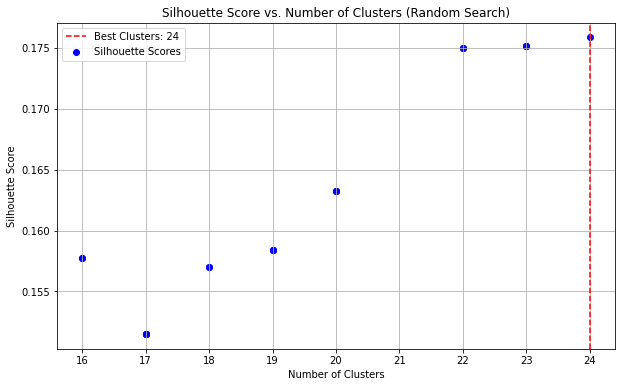

In [56]:
clusters = [res["clusters"] for res in results]
scores = [res["score"] for res in results]

plt.figure(figsize=(10, 6))
plt.scatter(clusters, scores, color='blue', label='Silhouette Scores')
plt.axvline(best_clusters, color='red', linestyle='--', label=f"Best Clusters: {best_clusters}")
plt.title("Silhouette Score vs. Number of Clusters (Random Search)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid()
plt.show()

In [57]:
n_clusters = 20

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
train_labels_gmm = gmm.fit_predict(train_images_pca)

silhouette_avg = silhouette_score(train_images_pca, train_labels_gmm)
print(f"GMM with {n_clusters} clusters:")
print(f"Silhouette Score: {silhouette_avg:.4f}")

GMM with 20 clusters:
Silhouette Score: 0.1632


In [58]:
cluster_counts = Counter(train_labels_gmm)
print("\nCluster distribution:")
for cluster, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster}: {count} samples")

unique_labels = set(train_labels_gmm)  
num_unique_labels = len(unique_labels)  
print(f"Number of unique labels: {num_unique_labels}")


Cluster distribution:
Cluster 0: 66 samples
Cluster 1: 38 samples
Cluster 2: 36 samples
Cluster 3: 39 samples
Cluster 4: 49 samples
Cluster 5: 72 samples
Cluster 6: 28 samples
Cluster 7: 35 samples
Cluster 8: 16 samples
Cluster 9: 24 samples
Cluster 10: 39 samples
Cluster 11: 79 samples
Cluster 12: 21 samples
Cluster 13: 35 samples
Cluster 14: 40 samples
Cluster 15: 37 samples
Cluster 16: 33 samples
Cluster 17: 19 samples
Cluster 18: 46 samples
Cluster 19: 48 samples
Number of unique labels: 20


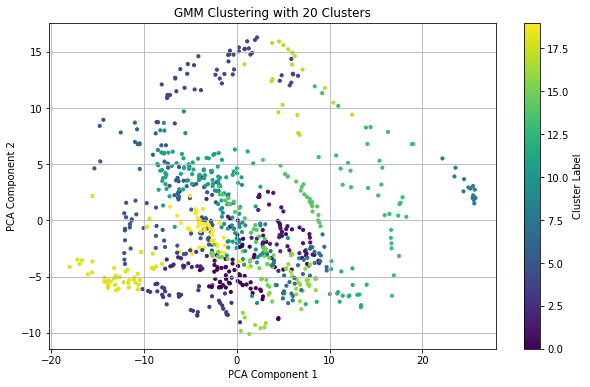

In [59]:
plt.figure(figsize=(10, 6))
plt.scatter(train_images_pca[:, 0], train_images_pca[:, 1], c=train_labels_gmm, cmap='viridis', s=10)
plt.title(f"GMM Clustering with {n_clusters} Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.grid()
plt.show()

In [60]:
test_labels_gmm = gmm.predict(test_images_pca)

test_cluster_counts = Counter(test_labels_gmm)
print("\nTest Cluster distribution:")
for cluster, count in sorted(test_cluster_counts.items()):
    print(f"Cluster {cluster}: {count} samples")
    
unique_labels = set(test_labels_gmm)  
num_unique_labels = len(unique_labels) 
print(f"Number of unique labels: {num_unique_labels}")


Test Cluster distribution:
Cluster 0: 12 samples
Cluster 1: 6 samples
Cluster 2: 5 samples
Cluster 3: 11 samples
Cluster 4: 9 samples
Cluster 5: 14 samples
Cluster 6: 5 samples
Cluster 7: 8 samples
Cluster 8: 2 samples
Cluster 9: 6 samples
Cluster 10: 9 samples
Cluster 11: 22 samples
Cluster 12: 4 samples
Cluster 13: 10 samples
Cluster 14: 5 samples
Cluster 15: 4 samples
Cluster 16: 7 samples
Cluster 17: 3 samples
Cluster 18: 7 samples
Cluster 19: 11 samples
Number of unique labels: 20


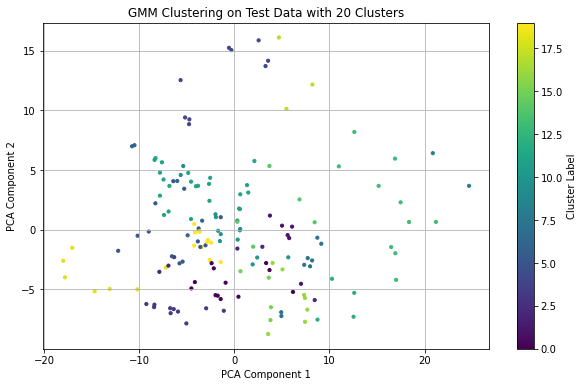

In [61]:
plt.figure(figsize=(10, 6))
plt.scatter(test_images_pca[:, 0], test_images_pca[:, 1], c=test_labels_gmm, cmap='viridis', s=10)
plt.title(f"GMM Clustering on Test Data with {n_clusters} Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster Label")
plt.grid()
plt.show()

In [62]:
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(train_labels, train_labels_gmm)
ari_score

0.32768806835021347

In [63]:
label_mapping = {label: i for i, label in enumerate(sorted(set(train_labels_gmm)))}

X_train_filtered = train_images_pca
y_train_filtered = [label_mapping[label] for label in train_labels_gmm]

X_test_filtered = test_images_pca
y_test_filtered = [label_mapping[label] if label in label_mapping else -1 for label in test_labels_gmm]

valid_test_indices = [i for i, label in enumerate(y_test_filtered) if label != -1]
X_test_filtered = X_test_filtered[valid_test_indices]
y_test_filtered = [y_test_filtered[i] for i in valid_test_indices]

In [64]:
num_classes = len(label_mapping)
y_train_filtered = tf.keras.utils.to_categorical(y_train_filtered, num_classes=num_classes)
y_test_filtered = tf.keras.utils.to_categorical(y_test_filtered, num_classes=num_classes)

print(f"Filtered Train Data Shape: {X_train_filtered.shape}, Train Labels Shape: {y_train_filtered.shape}")
print(f"Filtered Test Data Shape: {X_test_filtered.shape}, Test Labels Shape: {y_test_filtered.shape}")

Filtered Train Data Shape: (800, 350), Train Labels Shape: (800, 20)
Filtered Test Data Shape: (160, 350), Test Labels Shape: (160, 20)


In [65]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_filtered.shape[1],)),  
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')                           
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          44,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,484 (212.83 KB)

 Trainable params: 54,484 (212.83 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
history = model.fit(
    X_train_filtered, y_train_filtered,
    validation_split=0.2,  
    epochs=20,
    batch_size=32
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2335 - loss: 2.6931 - val_accuracy: 0.1375 - val_loss: 2.7188
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7970 - loss: 1.3551 - val_accuracy: 0.3750 - val_loss: 2.3880
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9379 - loss: 0.5649 - val_accuracy: 0.5375 - val_loss: 1.9204
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.2154 - val_accuracy: 0.5688 - val_loss: 1.7661
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0938 - val_accuracy: 0.5688 - val_loss: 1.7585
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0518 - val_accuracy: 0.5562 - val_loss: 1.7175
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0367 - val_accuracy: 0.5750 - val_loss: 1.7155
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0278 - val_accuracy: 0.5813 - val_loss

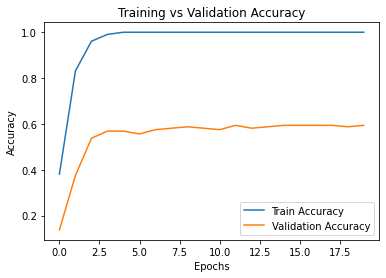

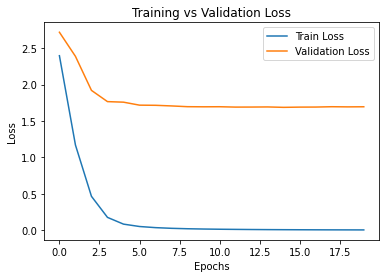

In [67]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
test_loss, test_accuracy = model.evaluate(X_test_filtered, y_test_filtered)
print(f"Filtered Test Accuracy: {test_accuracy * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9327 - loss: 0.1972
Filtered Test Accuracy: 87.50%


In [69]:
cluster_to_images_train = defaultdict(list)
for label, image in zip(train_labels_gmm, train_images_pca):  
    cluster_to_images_train[label].append(image)

cluster_to_images_test = defaultdict(list)
for label, image in zip(test_labels_gmm, test_images_pca):  
    cluster_to_images_test[label].append(image)

In [70]:
def inverse_transform_images(pca, images):
    
    reconstructed_images = pca.inverse_transform(images)  
    return np.array([image.reshape(112, 92) for image in reconstructed_images])

def display_all_images(cluster_to_images, dataset_name, pca):
    
    print(f"\n{dataset_name} Data Cluster Visualization:")
    for cluster, images in sorted(cluster_to_images.items()):
        print(f"Cluster {cluster}: {len(images)} images")
        
        reconstructed_images = inverse_transform_images(pca, np.array(images)) 
        
        num_images = len(reconstructed_images)
        num_rows = math.ceil(num_images / 10)  
        
   
        fig, axes = plt.subplots(
            num_rows, 10,
            figsize=(20, num_rows * 2), squeeze=False 
        )
        
        fig.suptitle(f"Cluster {cluster} ({dataset_name}) - All Images", fontsize=16, y=0.98)

        for i, img in enumerate(reconstructed_images):
            row, col = divmod(i, 10)
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].axis('off')
        
        for ax in axes.flat[num_images:]:
            ax.axis('off')
        
        plt.subplots_adjust(top=0.85, hspace=0.3, wspace=0.2)  
        plt.show()


Train Data Cluster Visualization:
Cluster 0: 66 images


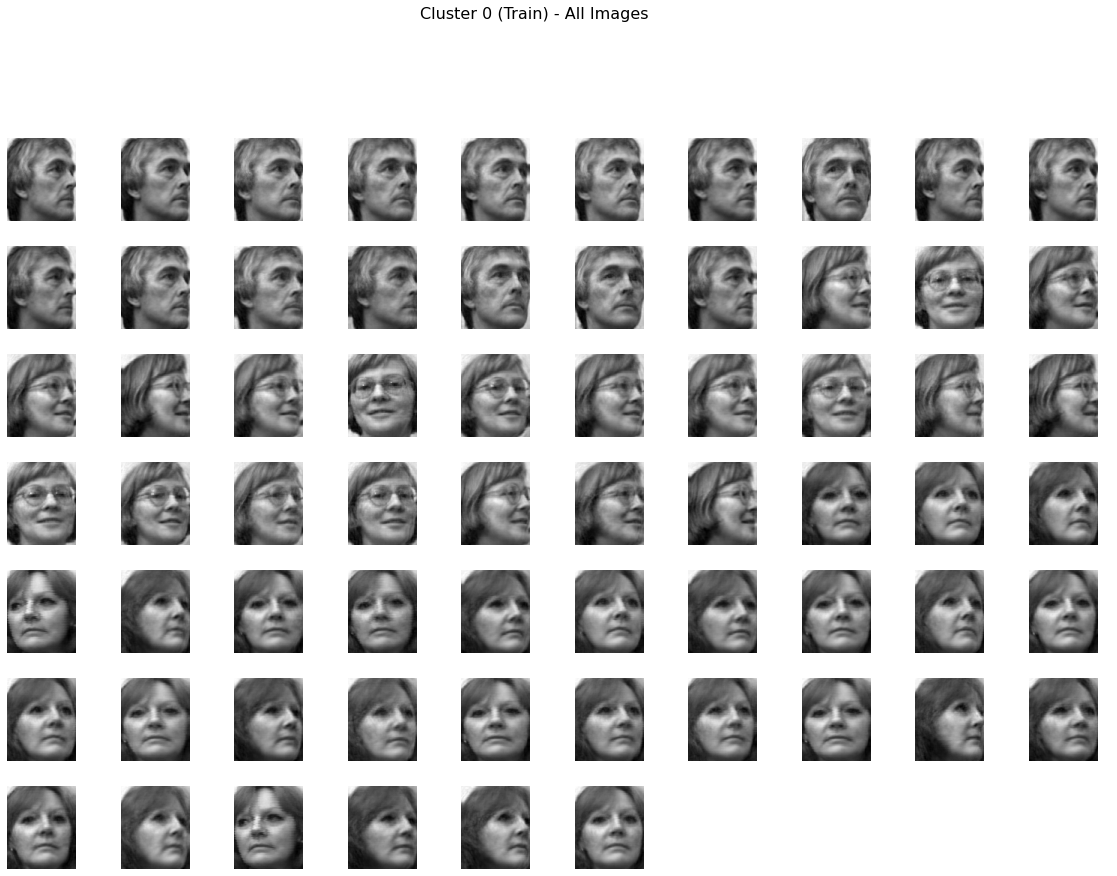

Cluster 1: 38 images


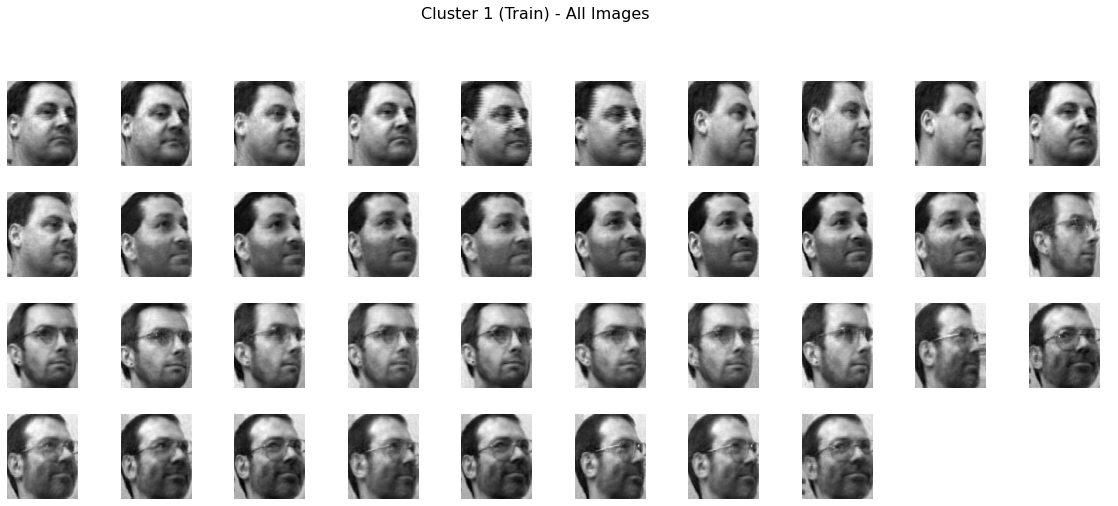

Cluster 2: 36 images


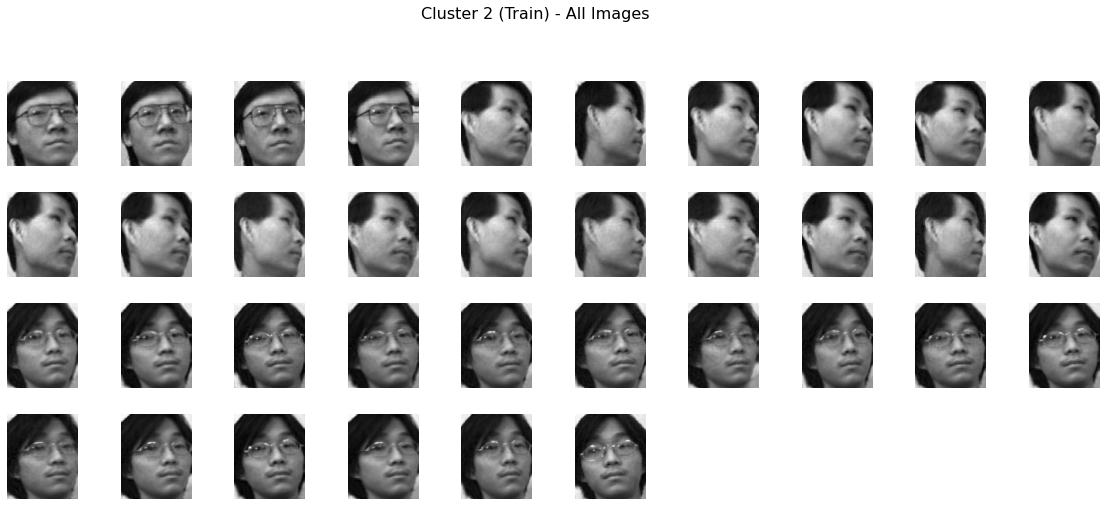

Cluster 3: 39 images


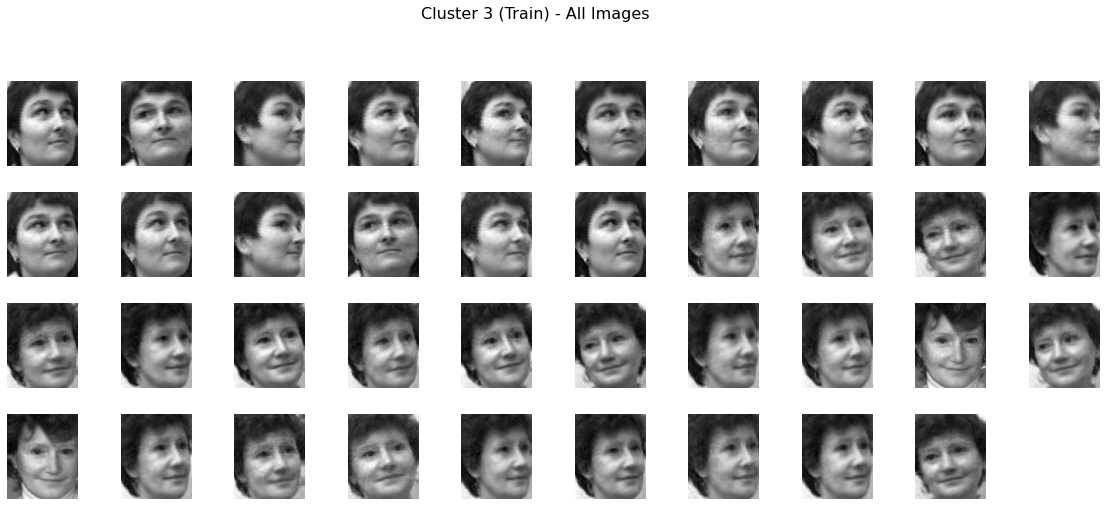

Cluster 4: 49 images


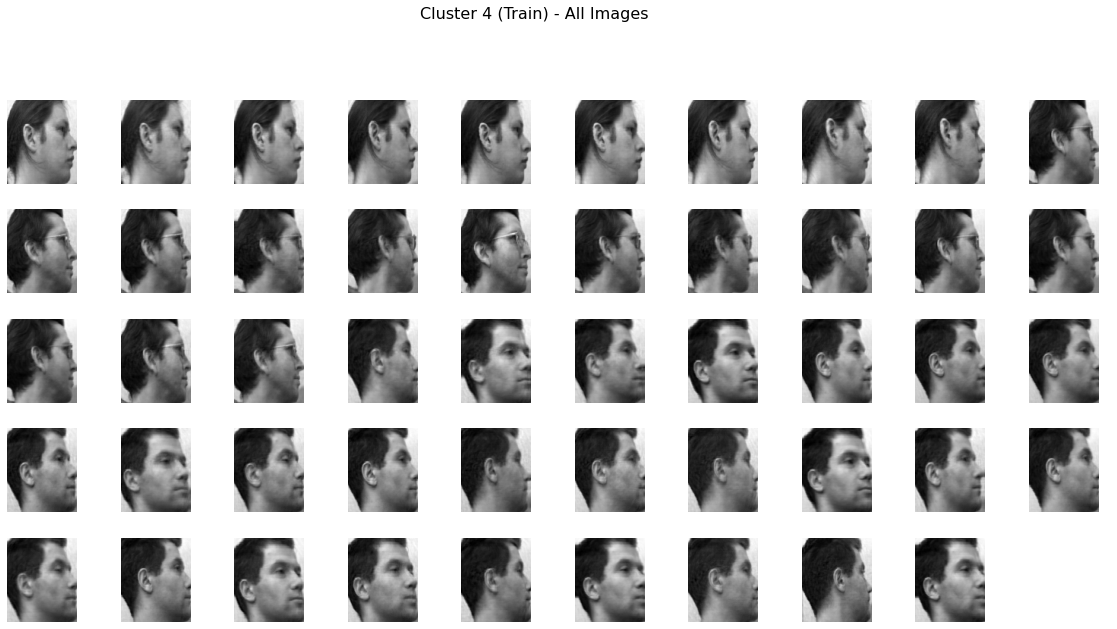

Cluster 5: 72 images


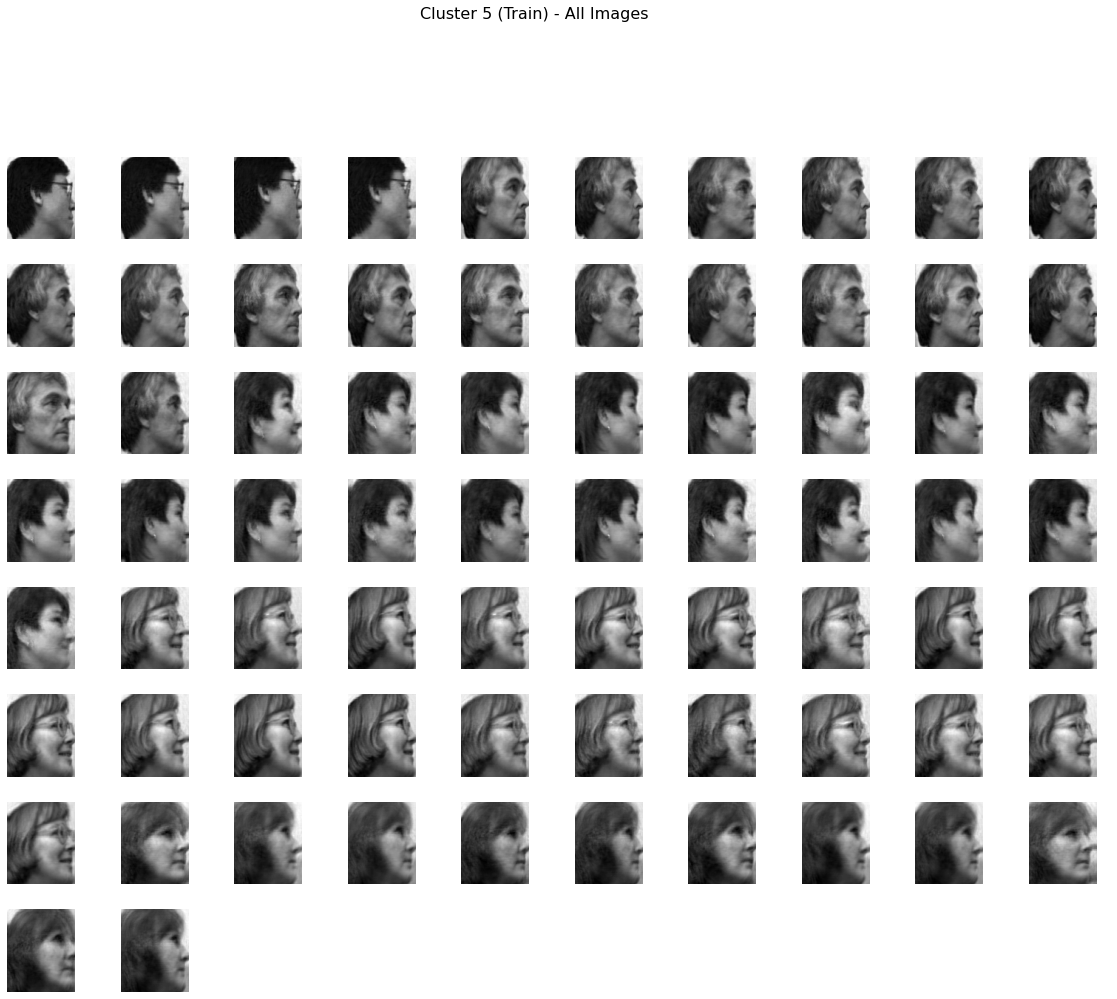

Cluster 6: 28 images


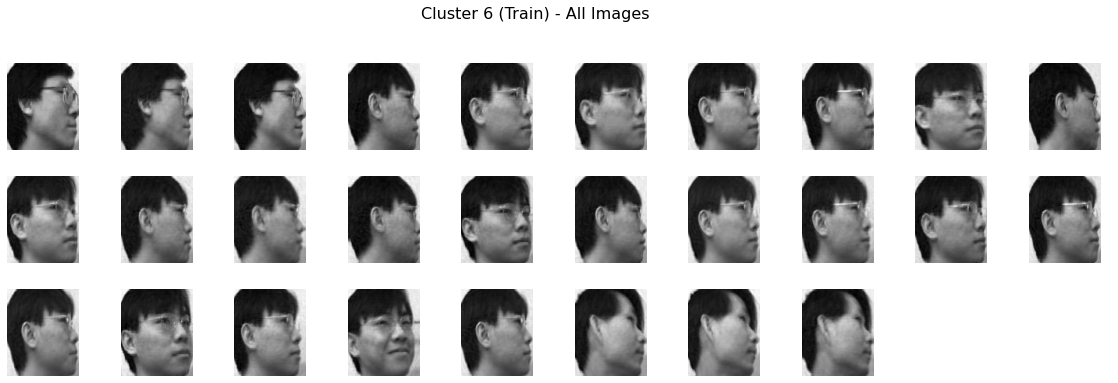

Cluster 7: 35 images


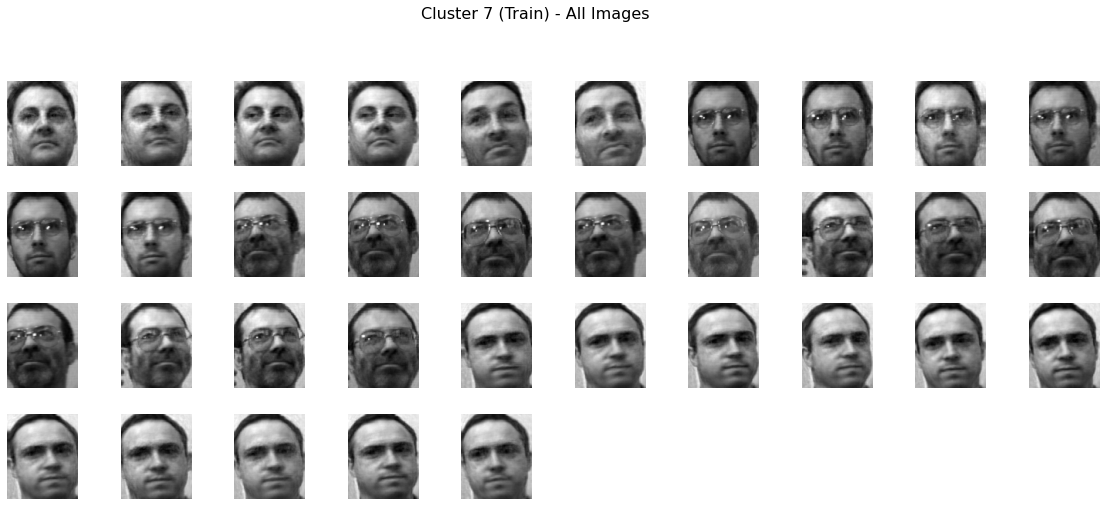

Cluster 8: 16 images


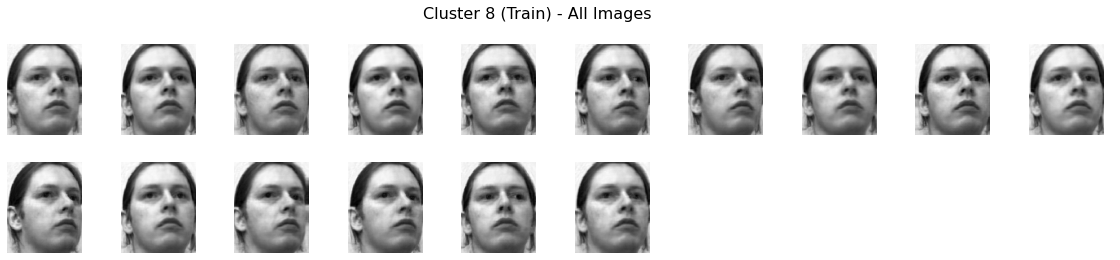

Cluster 9: 24 images


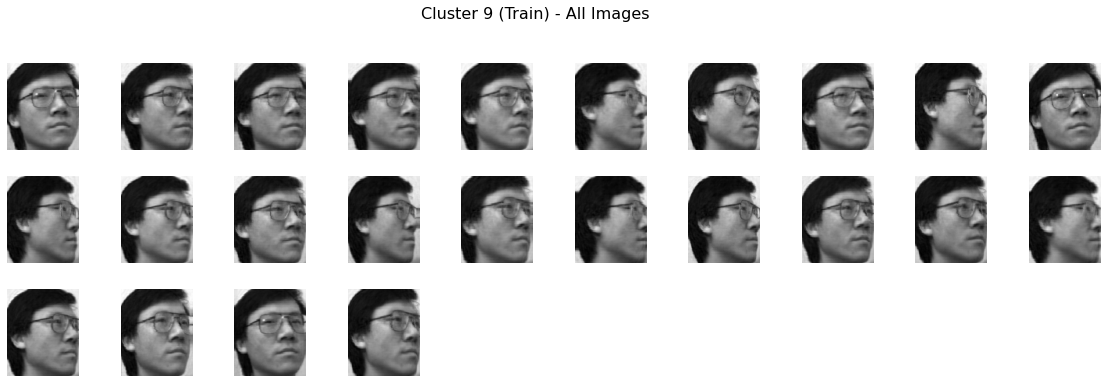

Cluster 10: 39 images


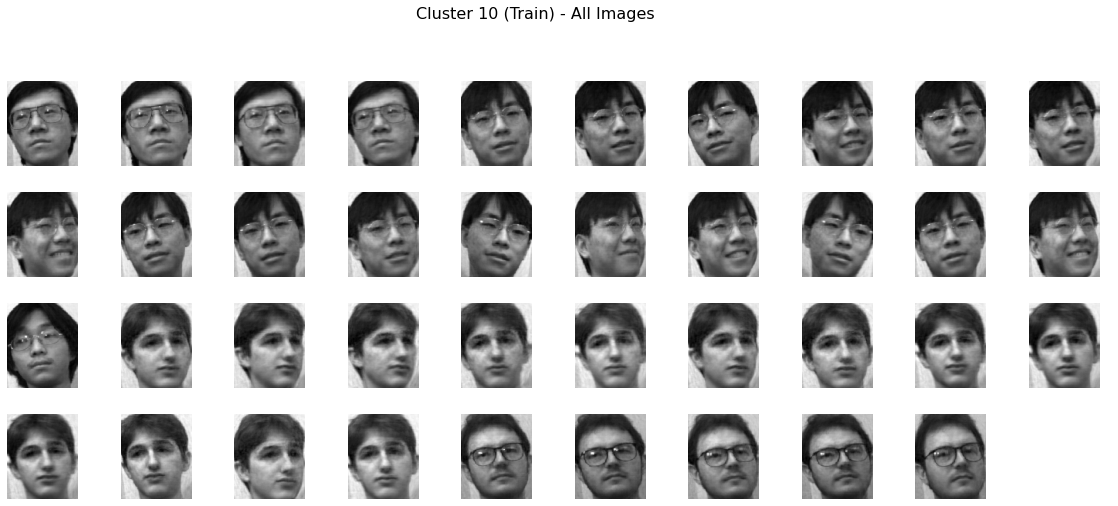

Cluster 11: 79 images


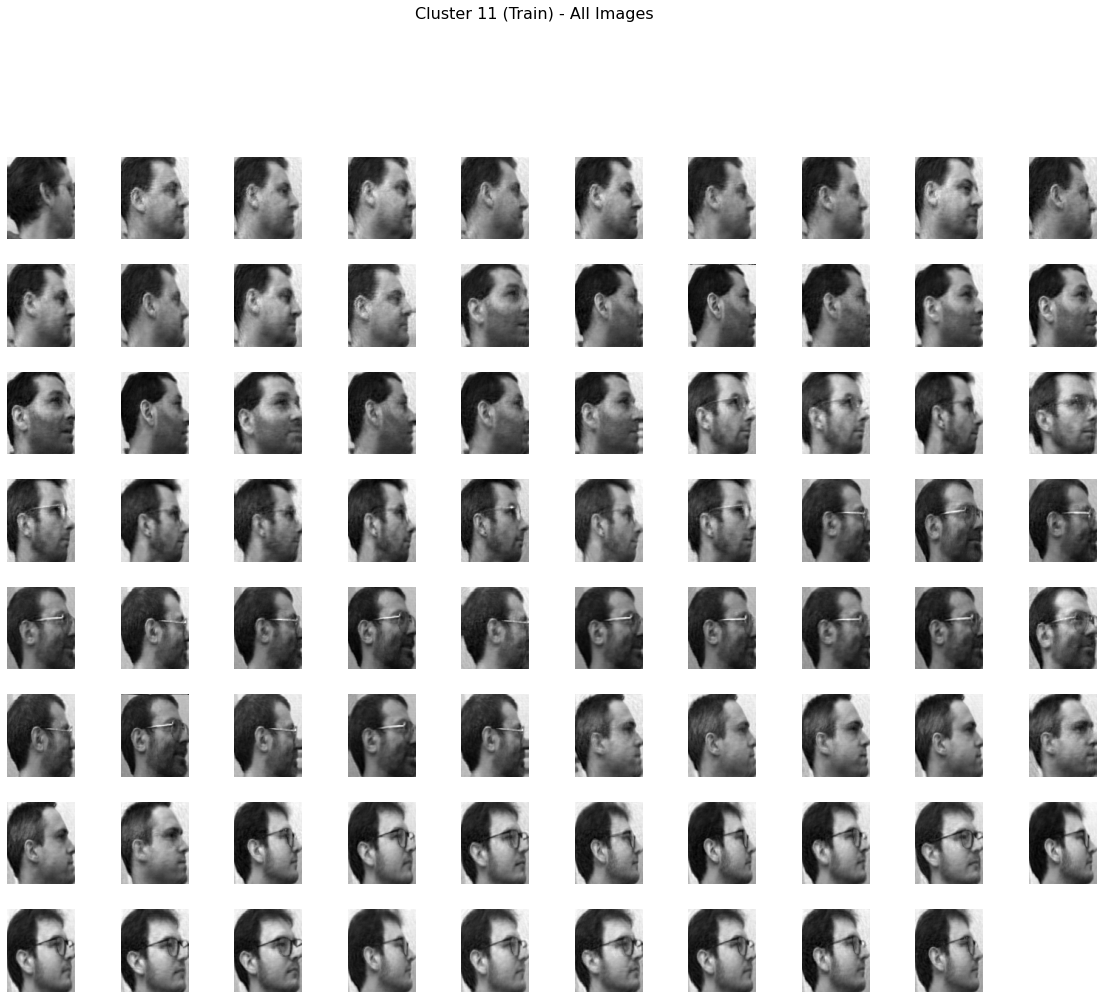

Cluster 12: 21 images


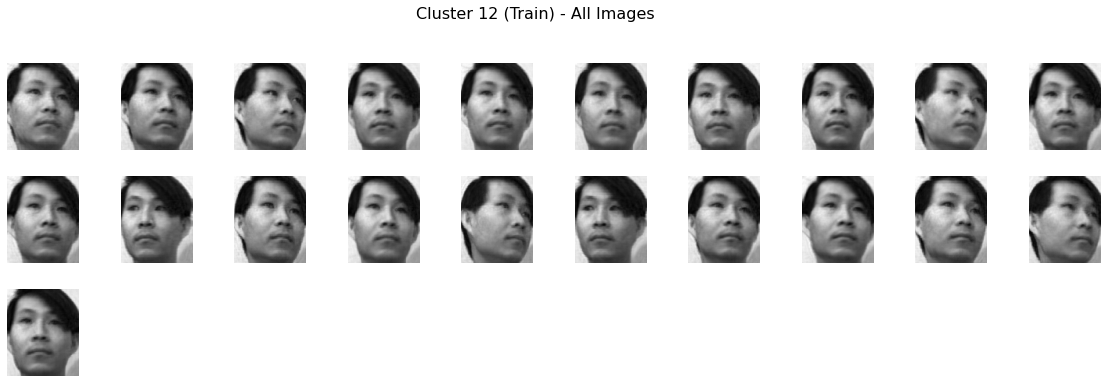

Cluster 13: 35 images


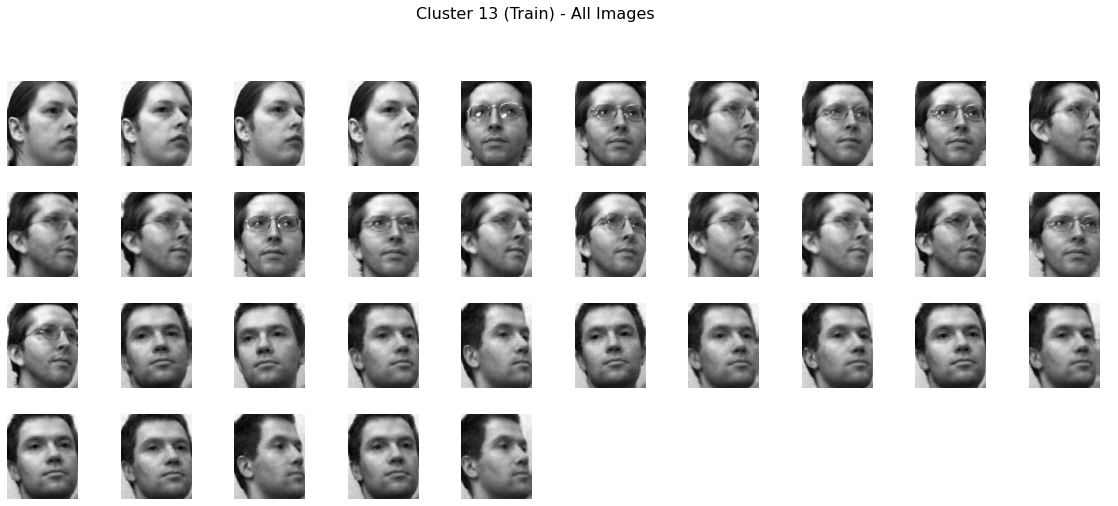

Cluster 14: 40 images


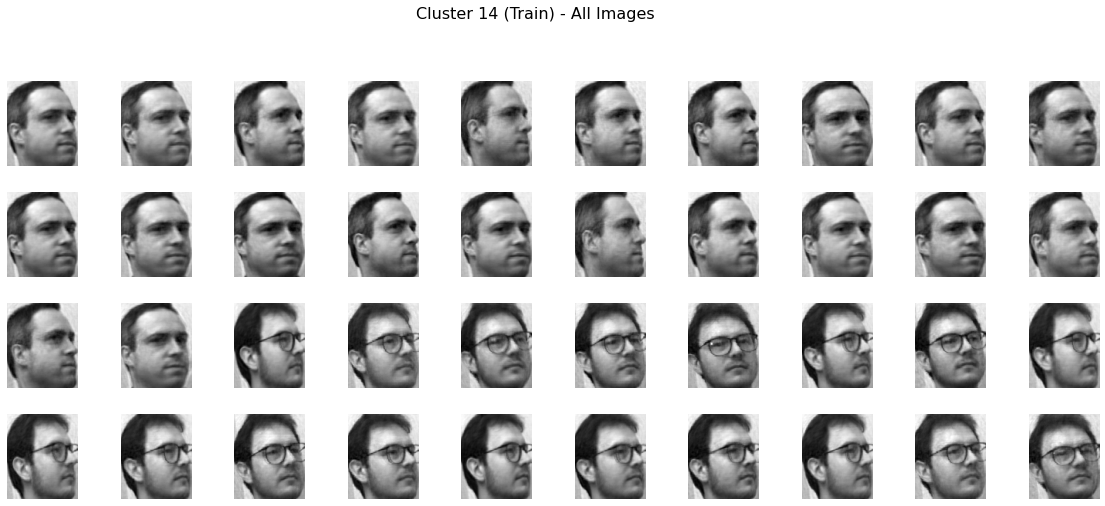

Cluster 15: 37 images


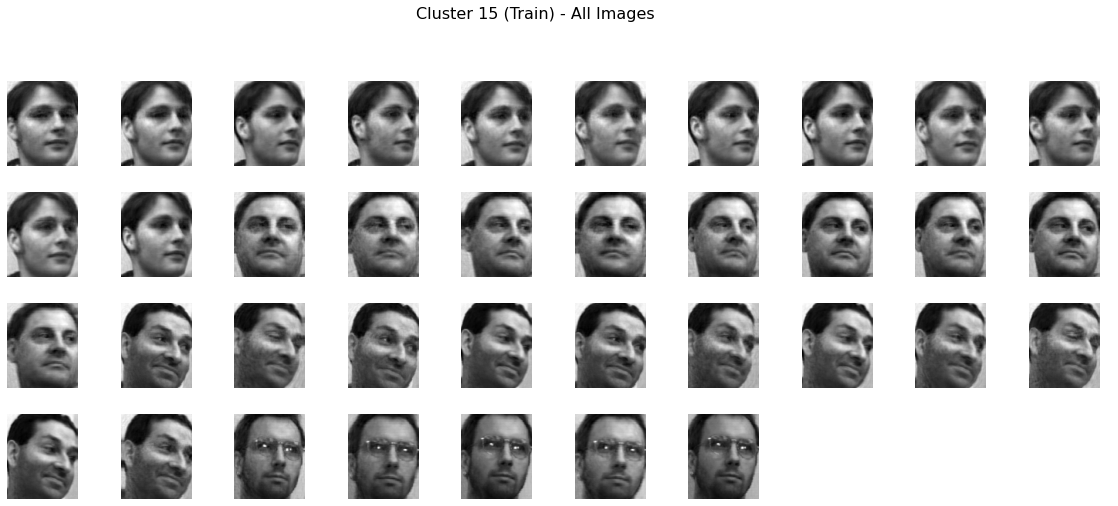

Cluster 16: 33 images


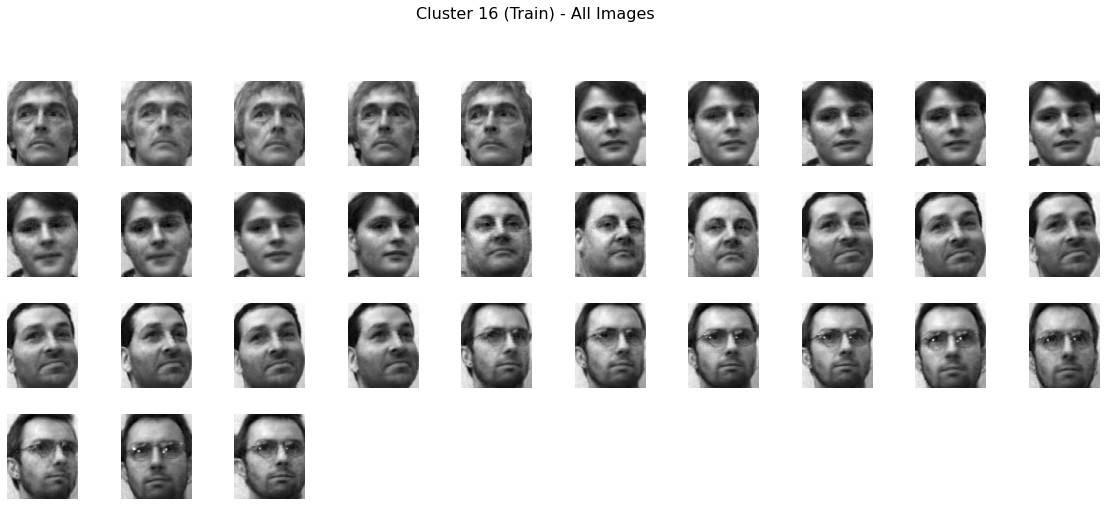

Cluster 17: 19 images


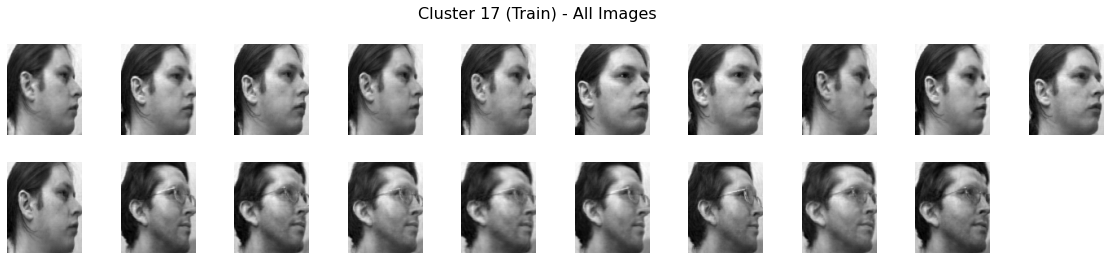

Cluster 18: 46 images


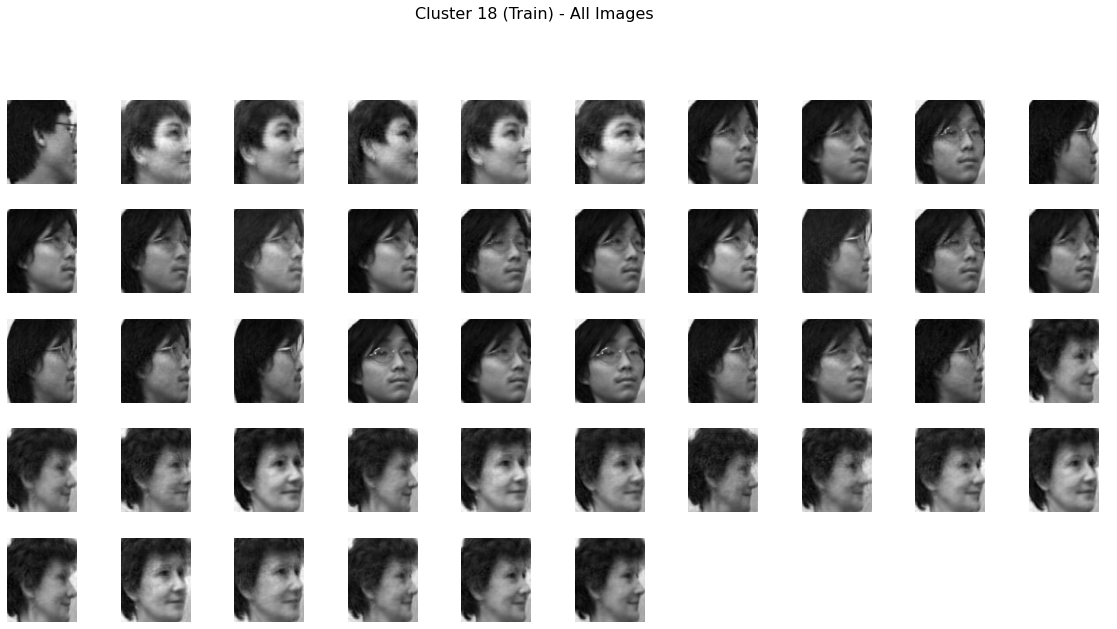

Cluster 19: 48 images


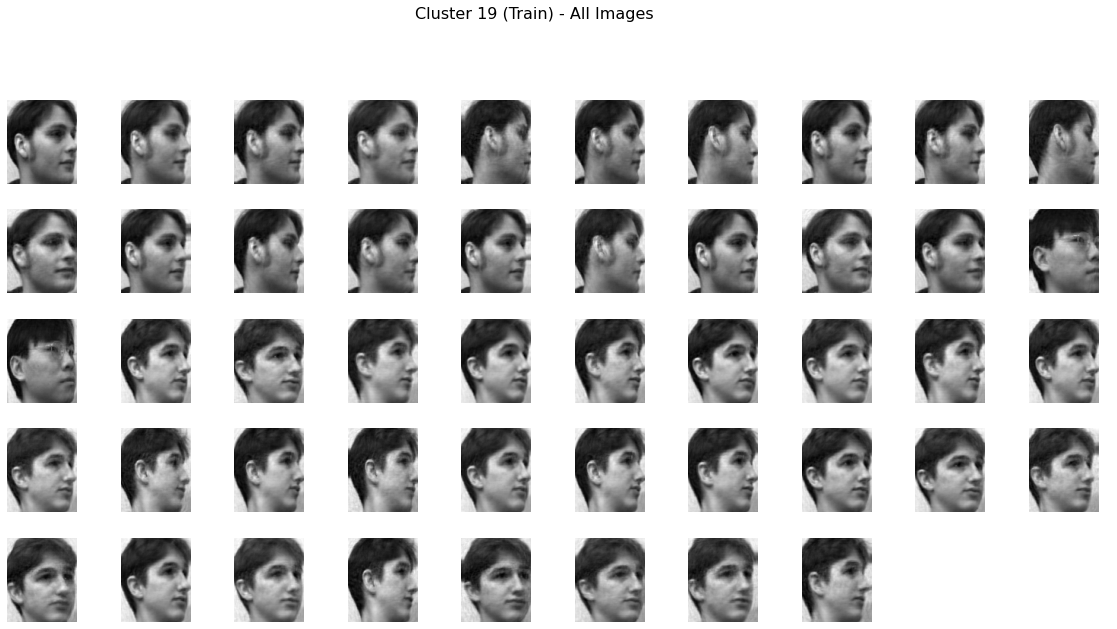

In [71]:
display_all_images(cluster_to_images_train, "Train", pca)


Test Data Cluster Visualization:
Cluster 0: 12 images


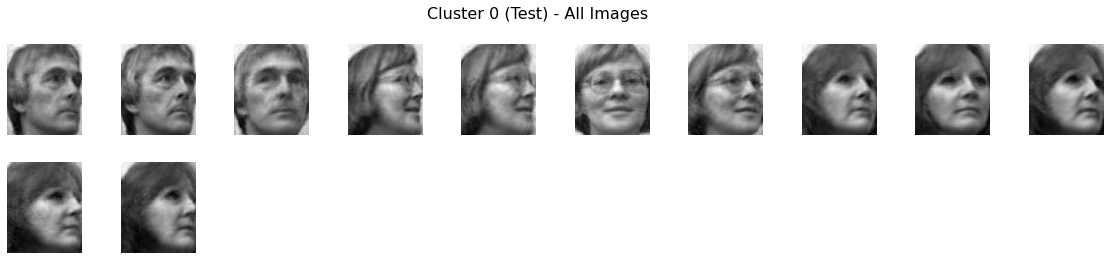

Cluster 1: 6 images


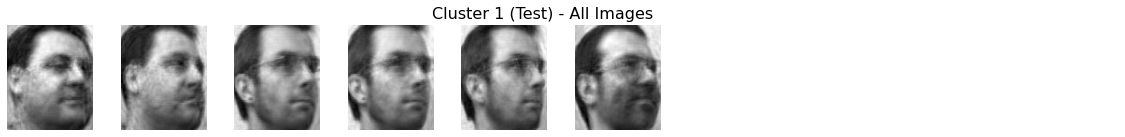

Cluster 2: 5 images


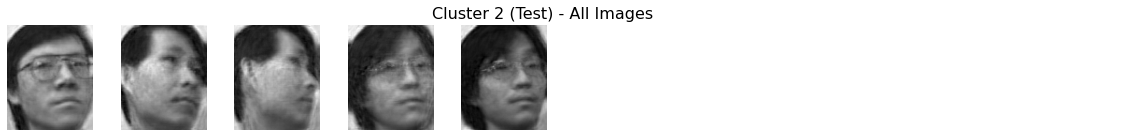

Cluster 3: 11 images


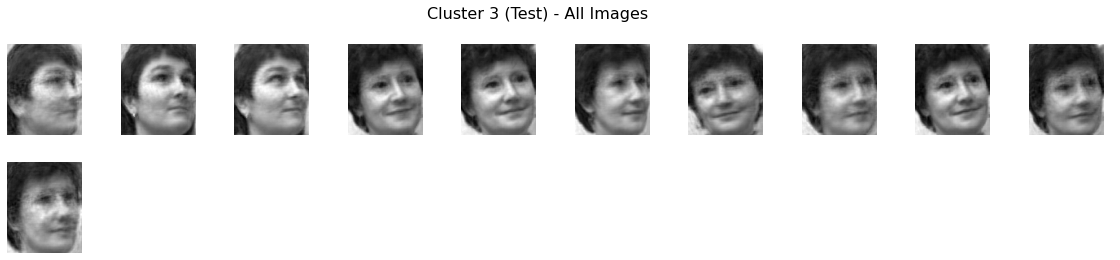

Cluster 4: 9 images


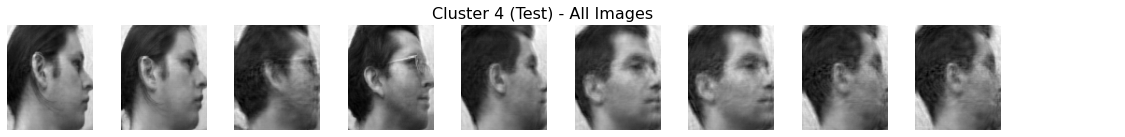

Cluster 5: 14 images


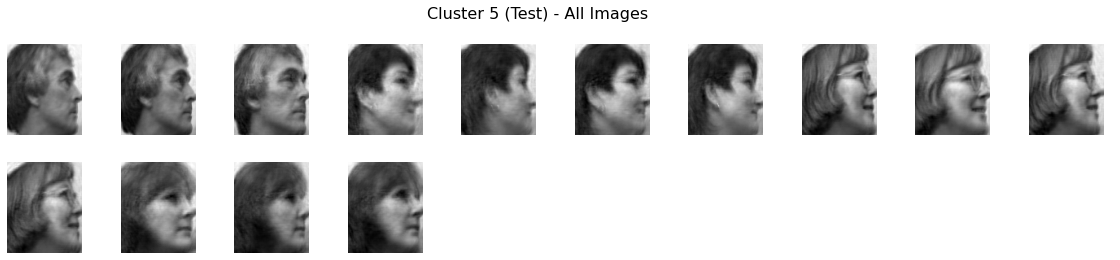

Cluster 6: 5 images


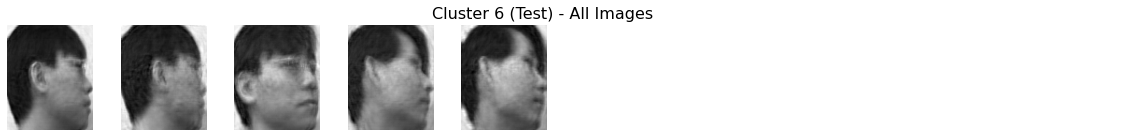

Cluster 7: 8 images


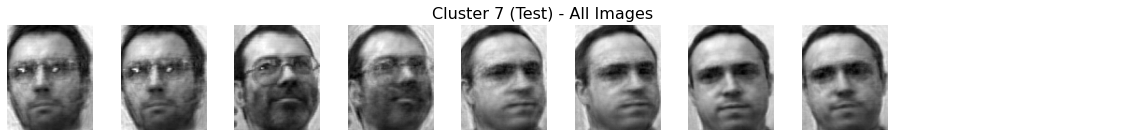

Cluster 8: 2 images


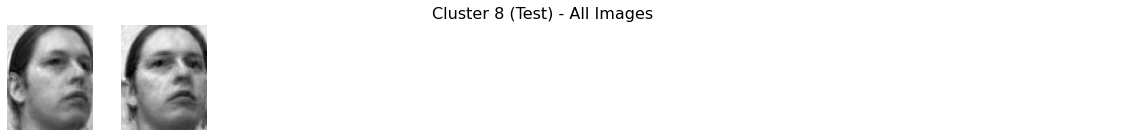

Cluster 9: 6 images


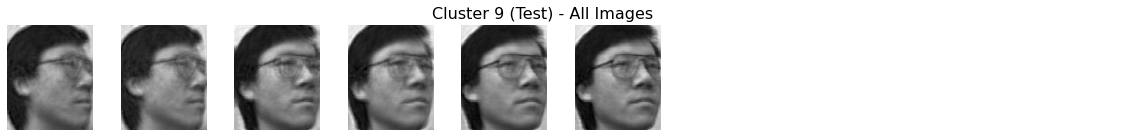

Cluster 10: 9 images


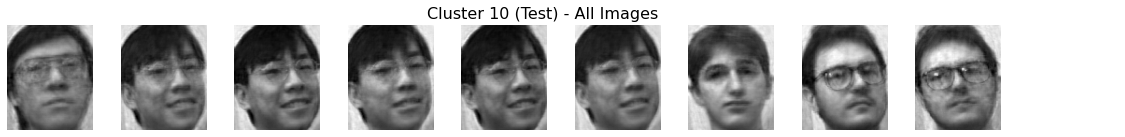

Cluster 11: 22 images


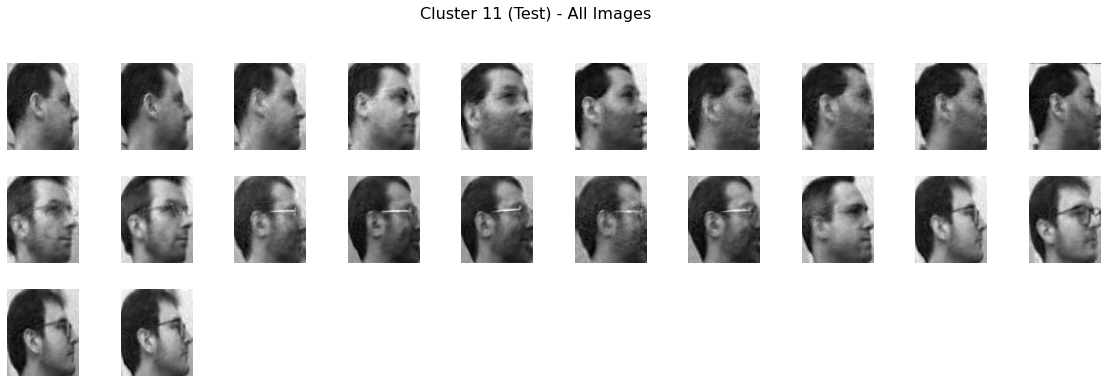

Cluster 12: 4 images


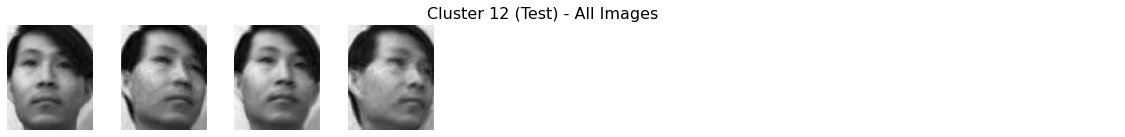

Cluster 13: 10 images


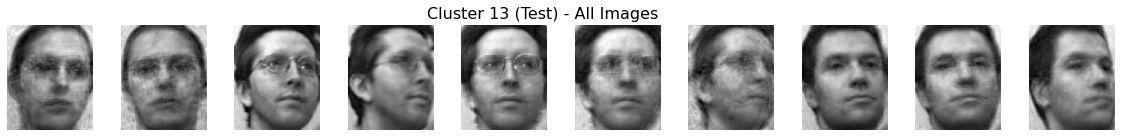

Cluster 14: 5 images


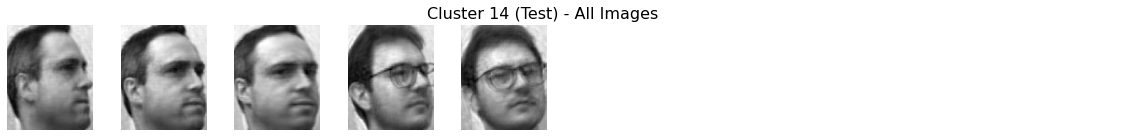

Cluster 15: 4 images


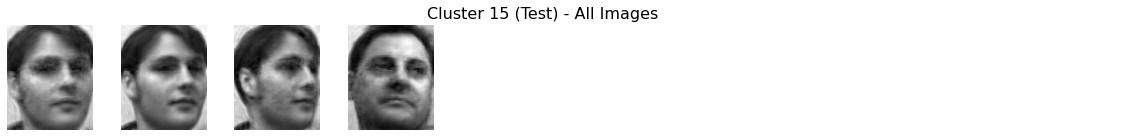

Cluster 16: 7 images


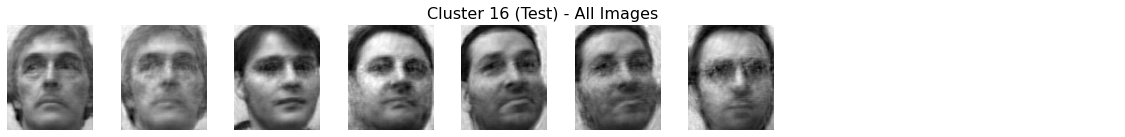

Cluster 17: 3 images


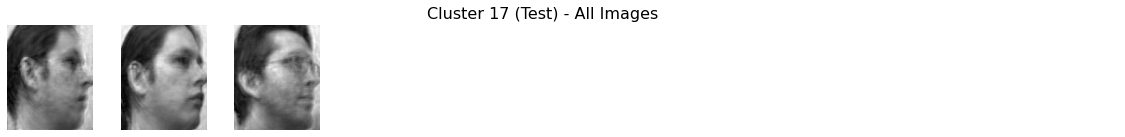

Cluster 18: 7 images


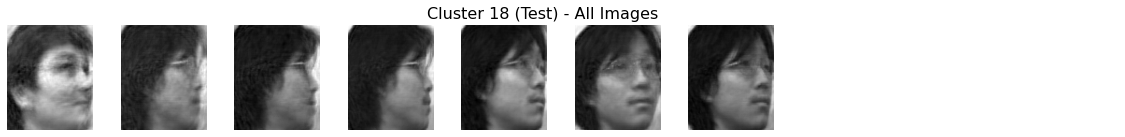

Cluster 19: 11 images


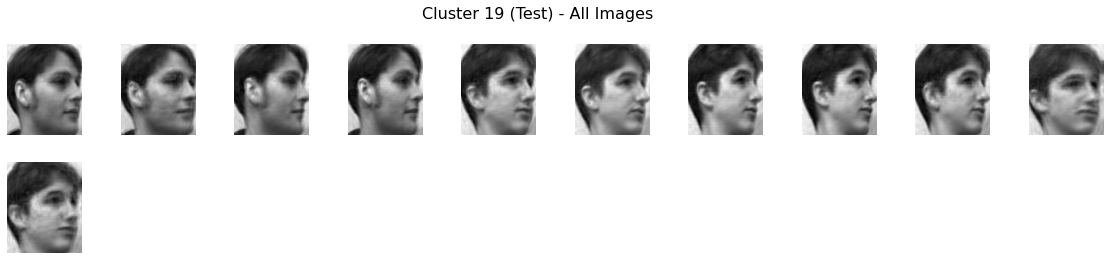

In [72]:
display_all_images(cluster_to_images_test, "Test", pca)